# Word Embeddings - Word2Vec and GloVe

- Let us build our first word embeddings ...
- **Important**: for all of the tasks below please make use of the provided methods given by the `gensim` and `nltk` Python module
- This is a  step-by-step coding example how to get from word representation to the corresponding word embeddings in order to use them for various downstream ML/DL-driven learning algroithms
- Have look at the `GENSIM` and `NLTK-LM` documentation: https://radimrehurek.com/gensim/ and https://www.nltk.org/api/nltk.lm.html

## Load Pre-Trained Word2Vec and GloVe Embeddings

- There exist a portfolio of existing word embeddings, trained on the basis of different text corpora and various underlying algorithmic concepts, such as `Word2Vec` or `GloVe`. Look up the `Python` method, which reports all the different models and training corpora which are available for download (Hint: check the dictonary `gensim.downloader.info()` for `models`) 
- Use the `api` module to `load` the pre-trained `Word2Vec` and `GloVe` model, trained on `google-news-300` and `twitter-200` (in case you face a Jupyter-internal `Warning: IOPub message rate exceeded`, you can either ignore it or get around it via starting Jupyter with the option `--NotebookApp.iopub_data_rate_limit=1.0e10`. No worries, the download itself, but also loading each of the two models, will take some time
- You will use both pre-loaded `Word2Vec` and `GloVe` models (for comparison), but also your own trained `Word2Vec` model

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gensim.downloader
import gensim.downloader as api

from matplotlib import cm
from sklearn.manifold import TSNE
from gensim.models import Word2Vec

In [2]:
model_twitter = api.load("glove-twitter-200")
model_google = api.load("word2vec-google-news-300")

## Loading, Extracting, Preprocessing, and Tokenizing (Sentences) of the Data Corpus for Downstream Model Training

- Use the same text document (`Donald-Trump-Tweets.csv`) as in the `N-GRAM` exercise, providing a series of different Tweets from Donald Trump 
- Prepare the entire data corpus including various Trump-Tweets, using a similar procedure as within the `N-GRAM` exercise, in terms of `loading, extracting, preprocessing, and tokenizing (sentences)` the data material
    - (1) `Pandas` Python library to read the `CSV`-file, filter the column which contains the text information (`Tweet_Text`), and check for empty/invalid elements
    - (2)  Clean and prepare (e.g. `regex`, `nltk` functionalities, etc.) the entire text information, to ensure a robust sentence tokenization (categorize (`NER`) patterns like hyperlinks, elements addressed via hashtags, dates, timestamps, multiple whitespaces, upper/lower case, etc.)
    - (3) Take the entire text information as one large `training` corpus (all the 7,375 lines) for downstream training of your word embedding model (later in the Jupyter notebook)
- `Sentence tokenization:` consider the fact that a single tweet often consists of multiple sentences, which has to be taken into account while building the sentences (`num_of_tweets << num_of_sentences`). Sentences should be stored (as for the `NGRAM` exercise) in a `nested list`, e.g. `[["my", "first", "sentences"], ["my", "second", "sentence"]]` (each sentence is represented as list of words (word vector $\vec{w}$))
- In terms of word embeddings, `stop words` often lead to undesired phenomena, due to a severe word-specific class imbalance. A `stop word` is very often `context word c_i` word and consequently often surrounded by topic-wise totally different words, which makes it hard to learn and derive a suitable vector representation. Therefor, in order to enhance the quality of the learned word embeddings, remove the `stop words` from the sentence list (make use of `from nltk.corpus import stopwords`, but if needed first download the pool of `stop words` via `nltk.download("stopwords")`).
- The identification of sentence beginning/end requires punctuation marks. However, when it comes to building the word embeddings, punctuation marks or any kind of remaining non-alphanumeric patterns (e.g. %, &, $, etc.) should be removed. Since you have your sentences already at this stage this is not a problem!
- How about padding the individual sentences with the start (`<s>`) and sentence end (`</s>`) tokens (as for `N-GRAM`)? Useful?

In [134]:
import re
import nltk
import string

from nltk.corpus import stopwords

trash_xps = [r'http\S+', r'@[\w_]+', r'#[\w_]+', r'\n', r'_', r'RT :', r'[-+]?[0-9]+']

def read_data(file):
    tweet_dataframe = pd.read_csv(file)
    tweet_table = tweet_dataframe["Tweet_Text"].dropna()
    return tweet_table

def rem_trash(patterns, sents):
    cleaned_sents = sents
    for pattern in patterns:
        cleaned_sents = [re.sub(pattern, '', sent) for sent in cleaned_sents]
    return cleaned_sents

def rem_double_whitespaces(sents):
    return [re.sub(r'  ', ' ', sent) for sent in sents]

def sents_to_nested_list(text):
    sentences = nltk.sent_tokenize(text)
    translator = str.maketrans('', '', string.punctuation)
    no_punc_sents = [sent.translate(translator) for sent in sentences]
    return [nltk.word_tokenize(sent) for sent in no_punc_sents]

def rem_stopwords(sents):
    stop_words = set(stopwords.words('english'))
    return [[word for word in sent if word not in stop_words] for sent in sents]

tweet_table = read_data("Donald-Trump-Tweets.csv")
cleaned_tweets = rem_double_whitespaces(rem_trash(trash_xps, tweet_table))

text = ' '.join(cleaned_tweets).lower()
nested_list = sents_to_nested_list(text)

preprocessed_tweets = rem_stopwords(nested_list)

## Apply Pre-Trained Word2Vec and GloVe models

- Use the pre-loaded `Word2Vec` and `GloVe` model and report the shape of a single word embedding vector for both of the models, as well as the overall size of the vocabulary. Are there differences in the vector embedding and vocabulary size and if so, how large is the difference? 
- Use both models throughout the exercise (same functionalities, but CAREFUL: `lower case vs. upper case` and `non-alphanumeric` differences for both models) in order to compute the cosine similarity $cos(\theta)$, by applying the `similarity` function for the following words pairs (all of the words below exist in both models, however, `lower/upper` case needs to be considered, as well as `non-alphanumeric`, symbols - you can also try others, of course!):
    - `Pikachu` vs. `Pokemon`
    - `Soccer` vs. `Football`
    - `Messi` vs. `Barcelona`
    - `Pele` vs. `Ronaldo`
    - `Orca` vs. `Whale`
    - `Prof.` vs. `Dr.`
- Report the `N=10` context words which present the highest similarity in terms of a given target word (descending order). Do not implement your own function, but rather make use of an existing function, provided by the model. Use the following target words: `student, trump, boxing, hospital, matrix & python` (you can also try others, of course)
- Look up and use the `doesnt_match` function - what is the underlying purpose?
- Compute various `analogies` via `positive`and `negative` word pairs (e.g. `positive=[woman king]`, `negative=[man]`, leading to `queen`) - use the same function as for computing the most similar context words (Hint: look for an existing function of the model!)
- Get the `dense vector` (word vector) from the trained word embedding matrix via `get_vector`, as well as the `index`for a specific word via `get_index`, both for the word `europe`
- Define a function `get_word_embeddings(words)` which `returns word clouds/clusters` for each given word in a `wordlist`, including the `10` closest (highest similarity) `context word embeddings` around a given list of `target words`. The dictionary output named `word cloud` has the following structure: `target word : {context_word_1 : ndarray_embed_vec, (...) , context_word_N : ndarray_embed_vec, target_word : ndarray_embed_vec}`

```
def get_word_embeddings(model, wordlist, topn):
    w_emb = []
    w_cloud = {}
    for t_w in words:
        #TODO - use "most_similar" function with target word "t_w"
        #TODO - get embedding for context word "c_w"
        #TODO - store everything (t_w, list of c_w embeddings) in a dictionary w_cloud (key = t_w, value = list of c_w)
    return w_cloud 
````

In [135]:
word2vec_vect = model_twitter.get_vector("afternoon")
glove_vect = model_google.get_vector("afternoon")

europe_vect_twitter = model_twitter.get_vector("europe")
europe_vect_google = model_google.get_vector("europe")

europe_index_twitter = model_twitter.get_index("europe")
europe_index_google = model_google.get_index("europe")

print(f'Twitter (GloVe) vector europe: {europe_vect_twitter}')
print(f'Google (word2vec) vector europe: {europe_vect_google}')

print()

print(f'Twitter (GloVe) index europe: {europe_index_twitter}')
print(f'Google (word2vec) index europe: {europe_index_google}')

print()

print(f'Twitter (GloVe) vector length: {len(word2vec_vect)}')
print(f'Google (word2vec) vector length: {len(glove_vect)}')

print()

print(f'Twitter (GloVe) vocab size: {len(model_twitter.key_to_index)}') #Get the respective vocabulary
print(f'Google (word2vec) vocab size: {len(model_google.key_to_index)}')

print()

print(f'Twitter (GloVe): {word2vec_vect}')
print(f'Google (word2vec): {glove_vect}')

Twitter (GloVe) vector europe: [ 3.2181e-01  1.2214e-02  2.2492e-01  2.1006e-01 -1.3460e-01 -2.4555e-01
  1.4192e-03  1.6350e-02  6.8561e-01 -1.7171e-01  4.5704e-01  4.1729e-01
 -1.0026e+00  2.7130e-01  4.8967e-01  2.5122e-02 -7.9318e-02 -2.0023e-01
 -3.7491e-01  5.3160e-02  3.5231e-01 -7.3898e-01  1.6720e-01  4.4965e-02
 -3.2994e-01  6.5803e-01  1.0924e-01 -1.2648e-01 -4.9101e-01 -9.6378e-02
  1.7919e-01 -7.5407e-02  3.4725e-03  4.5834e-02  7.7131e-01 -6.9012e-01
  8.8396e-03 -3.9292e-01  8.6437e-01  3.7245e-01  5.3764e-01 -3.1561e-01
  6.3571e-02 -3.1659e-01  3.3803e-01 -9.6649e-01  3.2558e-01 -7.4784e-01
  1.1676e-03  3.6727e-01  6.6016e-02  6.2463e-02  1.4373e-01  4.6204e-01
 -1.4333e-02 -5.4900e-02 -2.2821e-02  2.2778e-01  1.0818e-01 -2.7332e-01
  5.9262e-02  8.3647e-01 -9.9622e-02  3.5328e-01 -3.2144e-01  7.1657e-01
  4.1457e-01  2.6019e-01  6.4564e-01 -4.3277e-01 -2.5619e-01 -2.1487e-02
  6.2557e-01  8.7672e-01 -2.2824e-01 -6.4153e-01  3.1979e-01  2.8185e-01
  4.9826e-01  6.2761

In [136]:
print(f'Pikachu / Pokemon (GloVe): {model_twitter.similarity("pikachu", "pokemon")}')
print(f'Pikachu / Pokemon (Word2Vec): {model_google.similarity("Pikachu", "Pokemon")}')

print()

print(f'Soccer / Football (GloVe): {model_twitter.similarity("soccer", "football")}')
print(f'Soccer / Football (Word2Vec): {model_google.similarity("Soccer", "Football")}')

print()

print(f'Messi / Barcelona (GloVe): {model_twitter.similarity("messi", "barcelona")}')
print(f'Messi / Barcelona (Word2Vec): {model_google.similarity("Messi", "Barcelona")}')

print()

print(f'Pele / Ronaldo (GloVe): {model_twitter.similarity("pele", "ronaldo")}')
print(f'Pele / Ronaldo (Word2Vec): {model_google.similarity("Pele", "Ronaldo")}')

print()

print(f'Orca / Whale (GloVe): {model_twitter.similarity("orca", "whale")}')
print(f'Orca / Whale (Word2Vec): {model_google.similarity("Orca", "Whale")}')

print()

print(f'Prof. / Dr. (GloVe): {model_twitter.similarity("prof.", "dr.")}')
print(f'Prof. / Dr. (Word2Vec): {model_google.similarity("Prof.", "Dr.")}')

print()

print(f'Prof. / Dr. (GloVe): {model_twitter.similarity("musk", "maniac")}')
print(f'Prof. / Dr. (Word2Vec): {model_google.similarity("Musk", "Maniac")}')

Pikachu / Pokemon (GloVe): 0.6094618439674377
Pikachu / Pokemon (Word2Vec): 0.6372727751731873

Soccer / Football (GloVe): 0.8488518595695496
Soccer / Football (Word2Vec): 0.7229189872741699

Messi / Barcelona (GloVe): 0.7154593467712402
Messi / Barcelona (Word2Vec): 0.6065428256988525

Pele / Ronaldo (GloVe): 0.4440913200378418
Pele / Ronaldo (Word2Vec): 0.5526662468910217

Orca / Whale (GloVe): 0.43337270617485046
Orca / Whale (Word2Vec): 0.5591481924057007

Prof. / Dr. (GloVe): 0.6956897377967834
Prof. / Dr. (Word2Vec): 0.7368013262748718

Prof. / Dr. (GloVe): 0.13920724391937256
Prof. / Dr. (Word2Vec): 0.07255778461694717


In [137]:
def print_most_similar(N, words, model, model_name):
    [print(f'{word} ({model_name}): {model.most_similar(word, topn=N)}\n') for word in words]

words = ["student", "trump", "boxing", "hospital", "matrix", "python", "google"]

#print_most_similar(10, words, model_twitter, "GloVe")
#print("__________________________________________________________________________________________________________________________________________")
#print()
#print()
#print_most_similar(10, words, model_google, "Word2Vec")

def get_word_embeddings(words, model, N):
    embeddings = {}

    if N == 0:
        for word in words:
            curr_embed = {}
            curr_embed[word] = model.get_vector(word)
            embeddings[word] = curr_embed
        return embeddings
    
    for word in words:
        curr_embed = {}
        most_similar = model.most_similar(word, topn=N)
        curr_embed[word] = model.get_vector(word)
        for context_word in most_similar:
            curr_embed[context_word[0]] = model.get_vector(context_word[0])
        embeddings[word] = curr_embed
    return embeddings

print(get_word_embeddings(words, model_twitter, 10))

{'student': {'student': array([-1.5434e-01,  3.3746e-01,  2.2412e-01, -8.1967e-01, -1.6885e-01,
       -1.1408e-01,  5.3361e-01,  4.2071e-01, -1.4798e-01, -9.5925e-02,
       -4.8665e-01, -5.1137e-01, -5.7945e-01, -3.5690e-02,  8.6788e-01,
       -4.8137e-01,  2.8954e-01,  1.9389e-01, -2.1200e-01, -2.9546e-01,
        1.2947e-01,  5.6283e-01, -7.7369e-02, -2.8162e-01, -7.6388e-01,
        1.3752e+00,  6.9040e-02, -3.3319e-01,  2.7894e-01,  2.3838e-01,
        7.4485e-01, -5.7678e-01, -1.4714e-01,  2.9252e-01,  3.0483e-01,
        2.4254e-01,  4.5077e-01,  2.5160e-01,  4.3695e-01, -5.2755e-01,
        4.2495e-01, -5.2569e-02, -3.7705e-01, -2.1286e-01,  2.7817e-01,
        7.2274e-03, -4.4620e-01,  7.0630e-01, -2.1352e-01, -2.5969e-01,
       -1.8161e-01,  3.7207e-01, -5.8058e-01,  7.2987e-02, -1.3925e-01,
        5.6732e-03,  1.3539e-02, -1.7262e-01, -6.2571e-01,  2.9717e-01,
       -3.9053e-02, -1.2521e-01,  3.3444e-01,  4.1252e-01, -8.7956e-02,
        4.5332e-01,  4.4195e-01, -5.2718

## Compute Topic-Related Word Clouds

- Apply the function `get_word_embeddings(model, wordlist, topn)` to a number of topic-specific words `topics = yoda pizza orca hamburg mojito mercedes`, by converting `topics` to a `wordlist`. In addition, please select `topn=10`, resulting in the top-10 closest neighbors (words with the highest similarity) for each of those target words. As a result, the function `get_word_embeddings(model, wordlist, topn)` returns the word cloud object (10 surrounding word embeddings + 1 target word embedding for each topic). In case`topn=0` only the target word (no neighboring words) should be reported!
- Compute the topic-related `word cloud` information for both models: `Word2Vec` and `GloVe`
- The `word cloud` and its underlying high-dimensional word embeddings can now be used to visualize compact word relations 

In [138]:
topics = ["yoda", "pizza", "orca", "hamburg", "mojito", "mercedes"]

topics_google = get_word_embeddings(topics, model_google, 10)
topics_twitter = get_word_embeddings(topics, model_twitter, 10)
topics_twitter2 = get_word_embeddings(topics, model_twitter, 0)

print(topics_twitter2)

{'yoda': {'yoda': array([-0.048427 ,  0.048617 , -0.28356  ,  0.28762  , -0.28175  ,
        0.65428  ,  0.18702  , -0.49179  ,  0.51076  , -0.51977  ,
        0.14991  ,  0.11162  , -0.55436  ,  0.65812  ,  0.30135  ,
        0.3212   ,  0.8722   ,  0.6675   ,  0.58238  ,  0.2342   ,
       -0.1641   , -0.028955 , -0.3721   , -0.71817  ,  0.19645  ,
       -0.29088  ,  0.2147   , -0.22267  ,  0.91836  ,  0.18514  ,
       -0.12225  ,  0.72031  ,  0.3574   , -0.21888  , -0.21007  ,
        0.55165  , -0.36864  ,  0.2186   ,  0.76459  , -0.20397  ,
       -0.031208 ,  0.48655  , -0.27302  ,  0.28711  ,  0.42585  ,
       -0.1052   , -0.73296  ,  0.097354 ,  0.67232  , -0.069318 ,
        0.33001  ,  0.08077  ,  0.12111  , -0.0691   , -0.060783 ,
       -0.47404  ,  0.33539  , -0.88981  ,  0.51854  , -0.20429  ,
        0.20909  ,  0.26874  , -0.65687  , -0.37881  ,  0.21426  ,
       -0.35329  , -0.22566  ,  0.46041  ,  0.28658  ,  0.14796  ,
       -0.14904  ,  0.22861  , -1.0839   , -

## Visualization Word2Vec/GloVe embeddings
- Execute the code-snippet below, by calling the function: `tsne_plot(word_cloud, topn)` which takes the previous calculated `word cloud` information of the `topics`. The method reduces the dimensionality of the exisitng $M \times N$-large matrix to $M \times N=2$ dimensions, in order to visualize the individual `word clouds` on a 2D-grid. As type of dimensionality reduction technique a combination between `Principal Component Analysis (PCA)` and subsequent `t-distributed Stochastic Neighbor Embedding (TSNE)` is used.

You can consider the dimensionality reduction approach as `BlackBox`, however, you can also look it up in the respective documentations of `scikit-learn` (will be part of the `Machine Learning Lecture`)
- `TSNE` = https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html
- `PCA` = https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA  

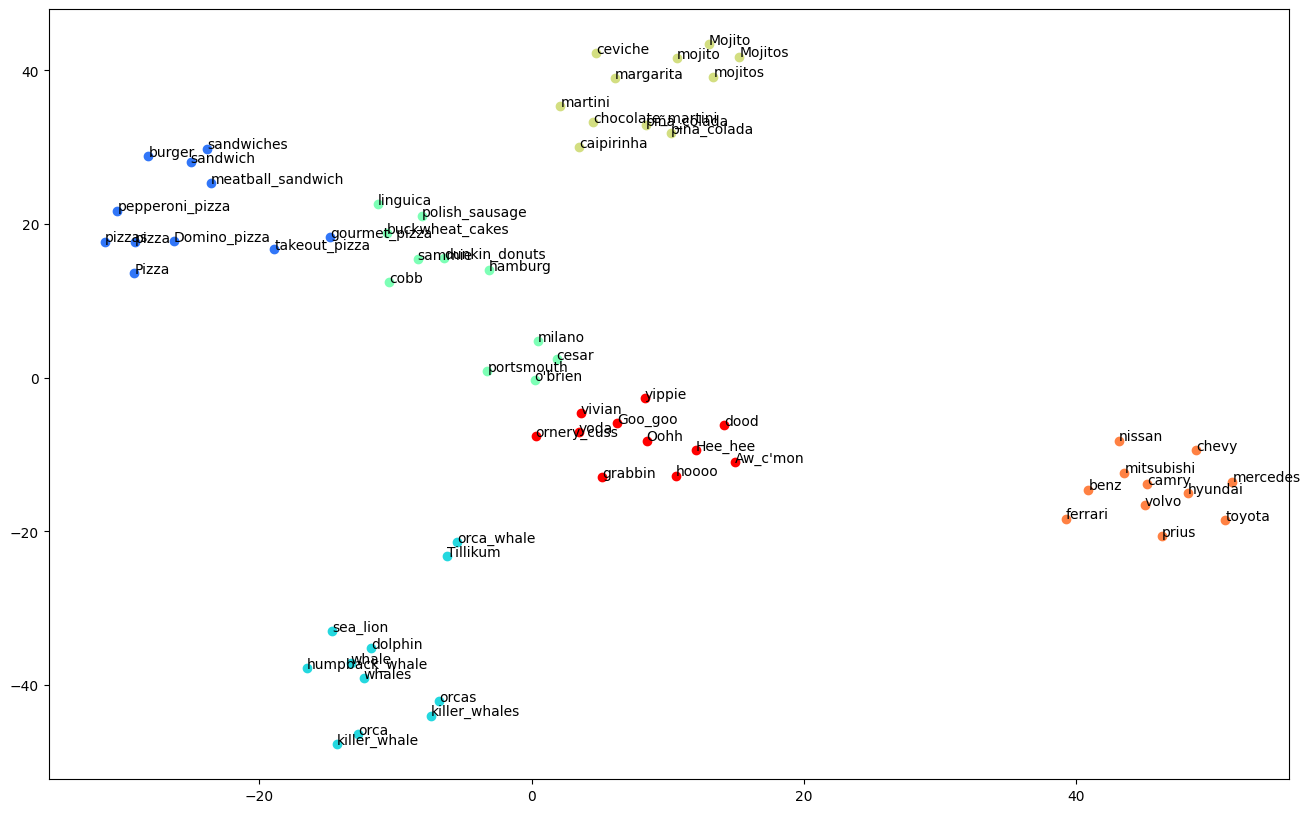

In [139]:
def get_labels_embeddings(word_cloud):
    embeddings=[]
    labels=[]
    for key in word_cloud:
        word_embed = word_cloud.get(key)
        for word in word_embed:
            labels.append(word)
            embeddings.append(word_embed.get(word))
    
    return np.array(labels), np.array(embeddings)

def tsne_plot(word_cloud, topn):
    labels, tokens = get_labels_embeddings(word_cloud)

    if topn != 0:
        colors = cm.rainbow(np.linspace(0, 1, len(labels))) 
    else:
        color = ["orange"]
    
    tsne_model = TSNE(perplexity=4, n_components=2, init='pca', n_iter=3500, random_state=10)
    tsne_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    
    for value in tsne_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 10)) 
    
    for i in range(len(x)):
        if topn != 0:
            if i % (topn+1) == 0:
                color = colors[i-1]
        plt.scatter(x[i],y[i],color=color)
        plt.annotate(labels[i], xy=(x[i], y[i]))
   
    plt.show()

tsne_plot(topics_google, 10)

## Build and Train your own Word2Vec-System 

- Train your own `Word2Vec` model using the `gensim Word2Vec` module together with the pre-processed Trump-Tweet sentence corpora `[["my", "first", "sentences"], (...), ["my", "second", "sentence"]]` and the following hyperparameters: `vector_size=300, window=5, min_count=1, workers=4` (have a look at the documentation, what does each parameters mean!)
- Report the vocabulary (`words` and `size`) of your trained `Word2Vec` (Hint: `index_to_key` function)

In [140]:
from gensim.models import Word2Vec

model = Word2Vec(sentences=preprocessed_tweets, vector_size=100, window=5, min_count=1, workers=4)
print(f'Size of own vocabulary: {len(model.wv.index_to_key)}')
print(f'Own vocabulary contents: {model.wv.index_to_key}')

Size of own vocabulary: 8223
Own vocabulary contents: ['trump', 'great', 'thank', 'amp', 'hillary', 'america', 'people', 'new', 'poll', 'make', 'donald', 'clinton', 'get', 'like', 'president', 'big', 'vote', 'tonight', 'time', 'one', 'us', 'crooked', 'cruz', 'going', 'debate', 'would', 'pm', 'last', 'country', 'back', 'join', 'many', 'today', 'said', 'never', 'good', 'win', 'much', 'iowa', 'night', 'watch', 'want', 'love', 'enjoy', 'media', 'bad', 'support', 'dont', 'polls', 'go', 'job', 'see', 'campaign', 'thanks', 'tomorrow', 'interviewed', 'jeb', 'rubio', 'nice', 'wow', 'amazing', 'crowd', 'cant', 'ted', 'really', 'need', 'show', 'obama', 'even', 'way', 'speech', 'day', 'got', 'bush', 'american', 'republican', 'carolina', 'best', 'morning', 'hampshire', 'news', 'jobs', 'via', 'mr', 'gop', 'interview', 'live', 'soon', 'years', 'rally', 'florida', 'right', 'know', 'must', 'candidate', 'state', 'totally', 'say', 'better', 'made', 'im', 'ohio', 'think', 'look', 'total', 'national', 'kee

## Evaluation of the Language Model 
- Evaluate your model by reporting word similarities for `america vs. great`, `great vs. again`, `trump vs. clinton`
- In addition also present the most similar words (top-15) for the word `fake`
- Feel free to try other word combinations with more and different evaluation techniques (as shown above for the pre-trained models)
- You can also visualize your entire vocabulary! Get your vocabulary as a list of words (`index_to_key`), compute the `get_word_embeddings(model, wordlist, topn)` with `topn=0`, because no other similar words should be shown (only target  word). Use the output of `get_word_embeddings(model, wordlist, topn)` and call `tsne_plot` with the same `topn=0`

In [148]:
def print_similarities(model, word_tupels):
    for tupel in word_tupels:
        print(f'Cosine similarity for {tupel[0]} and {tupel[1]}: {model.wv.similarity(tupel[0], tupel[1])}')

word_tupels = [("america", "great"), ("great", "make"), ("trump", "clinton")]

print_similarities(model, word_tupels)
print(model.wv.most_similar("fake", topn=15))

vocab = model.wv.index_to_key
embeds = get_word_embeddings(vocab, model.wv, 0)
tsne_plot(embeds, 0)

Cosine similarity for america and great: 0.9961776733398438
Cosine similarity for great and make: 0.9866333603858948
Cosine similarity for trump and clinton: 0.9982375502586365
[('center', 0.9967284798622131), ('well', 0.9966883659362793), ('speech', 0.9966859817504883), ('without', 0.9965697526931763), ('every', 0.9965023994445801), ('emails', 0.9964890480041504), ('show', 0.9964887499809265), ('polls', 0.9964667558670044), ('go', 0.9964432716369629), ('poll', 0.9964406490325928), ('history', 0.9964281916618347), ('policy', 0.996418297290802), ('women', 0.9963879585266113), ('ohio', 0.9963737726211548), ('today', 0.996367335319519)]


AttributeError: 'list' object has no attribute 'get_vector'

## Save and Store your final Model
- Store the trained and final `Word2Vec` model 
- Use  the `save` method to store your model at a given output path
- Call the `load` method to load your model based on a given input path. Verfiy the model after loading by computing the $cos(\theta)$ similarity for `trump vs. clinton`